#### Import the Dataset Into Pytorch

Use the `torchvision.datasets.ImageFolder` class to load the dataset.

In [1]:
from torchvision.datasets import ImageFolder

In [2]:
data_dir = 'C:\\Users\\DexTerMtor\\Desktop\\Flower-Species-Classification\\flowers'
dataset = ImageFolder(data_dir)

In [3]:
len(dataset)

4317

In [4]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=320x263>, 0)

In [5]:
dataset.classes

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

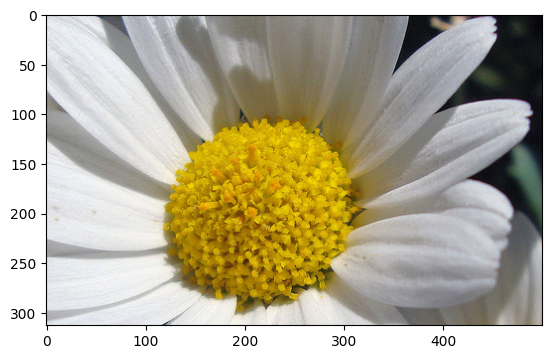

In [7]:
img, lable = dataset[1]
plt.imshow(img)

#### Data Augmentation and Normalization for Training

here we will croping and fixing the size of the image to 224x224 and then normalizing the image.

In [80]:
import torchvision.transforms as tt

dataset = ImageFolder(data_dir, tt.Compose([tt.Resize(64), 
                                            tt.RandomCrop(64),
                                            tt.ToTensor()]))

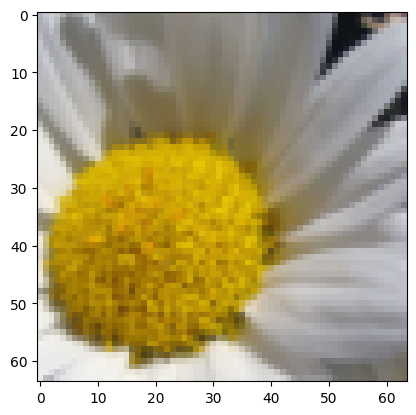

In [81]:
img, lable = dataset[1]
plt.imshow(img.permute((1,2,0)))

In [10]:
val_pct = 0.1
val_size = int(val_pct * len(dataset))
train_size = len(dataset) - val_size

train_size, val_size

(3886, 431)

In [11]:
from torch.utils.data import random_split, DataLoader

train_data, valid_data = random_split(dataset, [ train_size, val_size])
len(train_data), len(valid_data)

(3886, 431)

In [12]:
batch_size = 128

train_dl = DataLoader(train_data, 
                      batch_size,
                      shuffle=True,
                      num_workers = 4,
                      pin_memory=True)

valid_dl = DataLoader(valid_data,
                      batch_size,
                      num_workers=4,
                      pin_memory=True)

### making grid view for the training data of images

In [13]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6)) 
        ax.set_xticks([]) 
        ax.set_yticks([])  
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))  
        plt.show()
        break

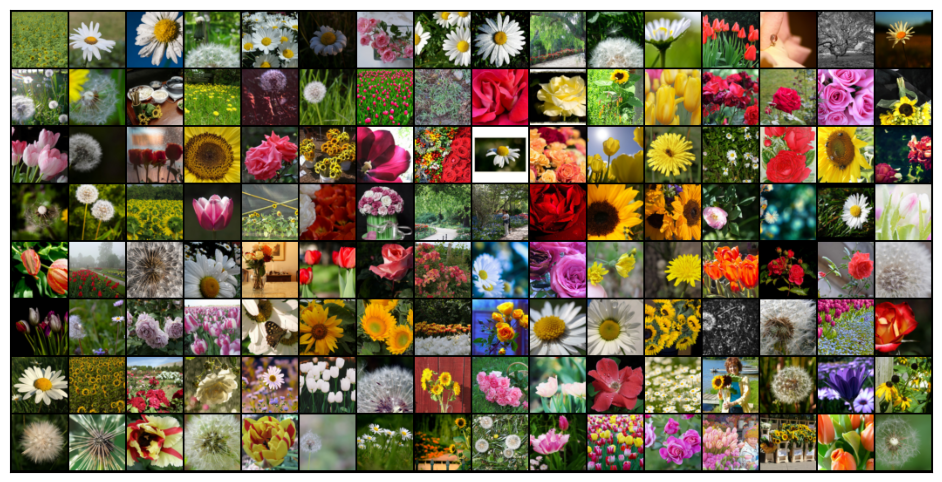

In [14]:
show_batch(train_dl)

GPU Configration

In [15]:
import torch

def check_gpus():
    # Check the number of available GPUs
    num_gpus = torch.cuda.device_count()
    print(f"Number of GPUs available: {num_gpus}")
    
    # Get the name of each GPU
    for i in range(num_gpus):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
    
    # Check the current GPU
    current_device = torch.cuda.current_device()
    print(f"Current GPU device: {current_device}")
    print(f"Device name: {torch.cuda.get_device_name(current_device)}")

    return num_gpus, current_device

def set_default_gpu(device_id):
    # Set the default GPU
    torch.cuda.set_device(device_id)
    print(f"Default device set to GPU {torch.cuda.current_device()}: {torch.cuda.get_device_name(torch.cuda.current_device())}")

# Check GPUs
num_gpus, current_device = check_gpus()

# Optionally, set a specific GPU as default (e.g., GPU 0)
if num_gpus > 1:
    set_default_gpu(0)  # Change the argument to the desired GPU ID


Number of GPUs available: 1
GPU 0: NVIDIA GeForce RTX 3050 Ti Laptop GPU
Current GPU device: 0
Device name: NVIDIA GeForce RTX 3050 Ti Laptop GPU


#### GPU Utility Functions and Classes for Training and Evaluation

In [98]:
import torch 

def get_default_device():
     """Pick GPU if available, else CPU"""
     if torch.cuda.is_available():
          return torch.device('cuda')
     else:
          return torch.device('cpu')

def to_device(data, device):
     """Move tensor(s) to choosen device"""
     if isinstance(data, (list,tuple)):
          return [to_device(x, device) for x in data]
     return data.to(device, non_blocking=True)

class DeviceDataLoader():
     """Wrap a dataloader to move data to device"""
     def __init__(self, dl, device):
          self.dl = dl
          self.device = device
     
     def __iter__(self):
          """Yield a batch of data after moving it to device"""
          for b in self.dl:
               yield to_device(b, self.device)
               
     def __len__(self):
          """Number of batches"""

          return len(self.dl)

In [17]:
device = get_default_device()

In [18]:
device

device(type='cuda')

#### loading traininig data and testing data on the gpu using dataloader

In [19]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

#### Model and Training the utilities

In [20]:
import torch.nn as nn
import torch.nn.functional as F
class ImageClassificationBase(nn.Module):
     """Calculate loss for a batch of training data"""
     def training_step(self, batch):
          images, labels = batch 
          out = self(images)                  # Generate predictions
          loss = F.cross_entropy(out, labels) # Calculate loss
          return loss
     
     """Calculate loss & accuracy for a batch of validation data"""
     def validation_step(self, batch):
          images, labels = batch 
          out = self(images)                    # Generate predictions
          loss = F.cross_entropy(out, labels)   # Calculate loss
          acc = accuracy(out, labels)           # Calculate accuracy
          return {'val_loss': loss.detach(), 'val_acc': acc}
          
     def validation_epoch_end(self, outputs):
          batch_losses = [x['val_loss'] for x in outputs]
          epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
          batch_accs = [x['val_acc'] for x in outputs]
          epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
          return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
     
     def epoch_end(self, epoch, result):
          print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [21]:
@torch.no_grad()
def evaluate(model, val_loader):
     """Evaluate the modal's performance ont the validation set"""
     model.eval()
     outputs = [model.validation_step(batch) for batch in val_loader]
     return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
     history = []
     optimizer = opt_func(model.parameters(), lr)
     for epoch in range(epochs):
          # Training Phase 
          model.train()
          train_losses = []
          for batch in train_loader:
               loss = model.training_step(batch)
               train_losses.append(loss)
               loss.backward()
               optimizer.step()
               optimizer.zero_grad()
          # Validation phase
          result = evaluate(model, val_loader)
          result['train_loss'] = torch.stack(train_losses).mean().item()
          model.epoch_end(epoch, result)
          history.append(result)
     return history

#### Defining the Model

In [22]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
     def __init__(self, in_channels, num_classes):
          super().__init__()
          #Input: 128 x 3 x 64 x 64
          self.conv1 = conv_block(in_channels, 64) # 128 x 64 x 64 x 64
          self.conv2 = conv_block(64, 128, pool=True) # 128 x 128 x 32 x 32
          self.res1 = nn.Sequential(conv_block(128, 128), # 128 x 128 x 32 x 32
                                    conv_block(128, 128)) # 128 x 128 x 32 x 32
          
          self.conv3 = conv_block(128, 256, pool=True) # 128 x 128 x 16 x 16
          self.conv4 = conv_block(256, 512, pool=True) # 128 x 512 x 8 x 8
          self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))# 128 x 512 x 8 x 8
          
          self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), # 128 x 512 x 1 x 1
                                             nn.Flatten(), # 128 x 512
                                             nn.Dropout(0.2),
                                             nn.Linear(512, num_classes))
          
     def forward(self, xb):
          out = self.conv1(xb)
          out = self.conv2(out)
          out = self.res1(out) + out
          out = self.conv3(out)
          out = self.conv4(out)
          out = self.res2(out) + out
          out = self.classifier(out)
          return out

In [23]:
model = to_device(ResNet9(3, len(dataset.classes)), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [24]:
model.conv1[0].weight.device

device(type='cuda', index=0)

Pass one batch of input tensor through the model to check the output shape.

In [25]:
torch.cuda.empty_cache()
for batch in train_dl:
     images, lables = batch
     print('images.shape', images.shape)
     print('images.device',images.device)
     preds = model(images)
     print('preds.shape', preds.shape)
     print(preds)
     break

images.shape torch.Size([128, 3, 64, 64])
images.device cuda:0
preds.shape torch.Size([128, 5])
tensor([[-2.0609e+00, -7.3868e-01,  2.6104e+00, -4.1929e+00,  7.1309e+00],
        [-6.5723e-01, -1.2276e-01,  7.1990e-01, -1.1560e+00,  5.2368e+00],
        [-5.1247e-01,  2.5776e+00, -9.2398e-01, -2.1202e+00,  1.6847e+00],
        [ 1.1265e+00, -9.7712e-01,  1.8606e+00, -5.0981e+00,  2.8335e+00],
        [ 2.8760e-01,  1.0092e+00, -1.1614e+00, -2.1695e+00,  1.1661e+00],
        [ 3.1589e-01, -1.1289e+00, -2.6489e+00, -3.4035e+00, -5.8472e-01],
        [ 5.0739e-01,  1.6589e+00,  3.3907e-01, -3.2005e+00,  3.8240e+00],
        [-2.5508e-02,  9.8451e-04,  6.3797e-01, -2.4305e+00,  1.8579e+00],
        [ 2.2263e-01,  6.3981e-01,  3.1239e-01, -1.2840e-01,  2.0333e+00],
        [-1.9093e+00, -4.8485e-01,  3.2752e-01, -1.9173e+00,  2.3366e+00],
        [ 1.2838e+00,  1.0159e+00, -2.1684e+00, -1.1840e+00,  2.5726e+00],
        [ 2.7994e+00, -1.0397e-01, -9.5611e-01, -1.0995e+00,  3.9125e+00],
    

#### Training the Model

In [26]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 1.6103241443634033, 'val_acc': 0.20661568641662598}]

In [27]:
history += fit(5, 0.001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 1.4580, val_loss: 1.4745, val_acc: 0.3957
Epoch [1], train_loss: 0.9308, val_loss: 0.9724, val_acc: 0.6548
Epoch [2], train_loss: 0.8339, val_loss: 0.9920, val_acc: 0.6188
Epoch [3], train_loss: 0.7569, val_loss: 1.4647, val_acc: 0.5210
Epoch [4], train_loss: 0.7216, val_loss: 0.9951, val_acc: 0.6280


In [28]:
history += fit(5, 0.001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.8975, val_loss: 0.8067, val_acc: 0.7249
Epoch [1], train_loss: 0.7223, val_loss: 0.6959, val_acc: 0.7483
Epoch [2], train_loss: 0.6054, val_loss: 0.7495, val_acc: 0.7609
Epoch [3], train_loss: 0.5401, val_loss: 1.1679, val_acc: 0.6422
Epoch [4], train_loss: 0.5271, val_loss: 0.5999, val_acc: 0.7819


In [29]:
history += fit(5, 0.0001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.4006, val_loss: 0.5201, val_acc: 0.8131
Epoch [1], train_loss: 0.3524, val_loss: 0.5023, val_acc: 0.8316
Epoch [2], train_loss: 0.3422, val_loss: 0.5065, val_acc: 0.8165
Epoch [3], train_loss: 0.3263, val_loss: 0.4954, val_acc: 0.8442
Epoch [4], train_loss: 0.3068, val_loss: 0.5015, val_acc: 0.8506


In [30]:
history += fit(5, 0.0001, model, train_dl, valid_dl)

Epoch [0], train_loss: 0.2930, val_loss: 0.5121, val_acc: 0.8316
Epoch [1], train_loss: 0.2881, val_loss: 0.5069, val_acc: 0.8428
Epoch [2], train_loss: 0.2800, val_loss: 0.4986, val_acc: 0.8374
Epoch [3], train_loss: 0.2969, val_loss: 0.4886, val_acc: 0.8369
Epoch [4], train_loss: 0.2793, val_loss: 0.5090, val_acc: 0.8335


In [31]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')

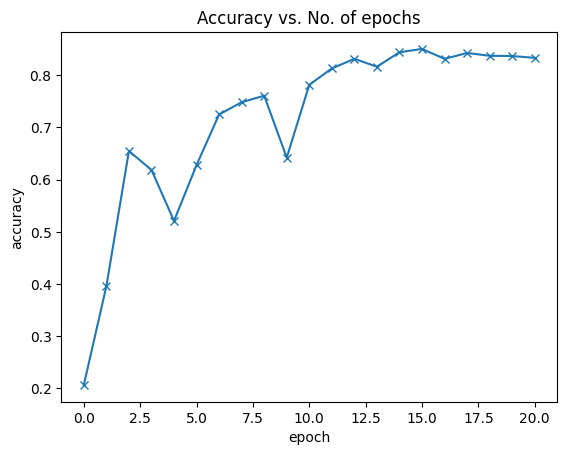

In [32]:
plot_accuracies(history)

In [33]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')

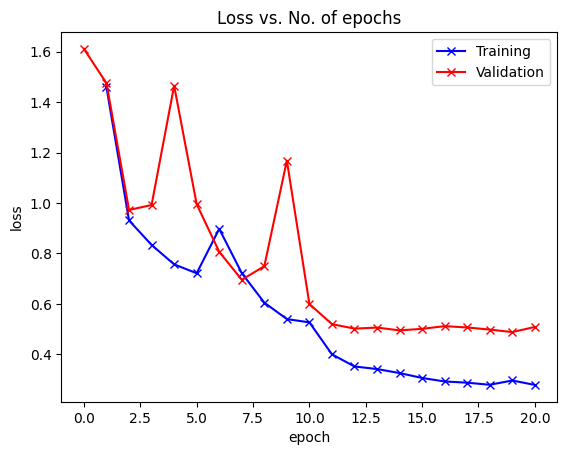

In [34]:
plot_losses(history)

#### Record the Results

In [61]:
import pandas as pd

def log_matrix(batch_size, architecture, epochs, lrs, opt, train_loss, val_acc, val_loss):
    log = {
        'Parameter':'Values',
        'Batch Size': [batch_size],
        'Architecture': [architecture],
        'Epochs': [epochs],
        'Learning Rate(s)': [lrs],
        'Optimizer': [opt],
        'Training Loss': [train_loss],
        'Validation Accuracy': [val_acc],
        'Validation Loss': [val_loss]
    }

    log_matrix = pd.DataFrame(log)
    log_matrix = log_matrix.T
    log_matrix.columns = log_matrix.iloc[0]
    log_matrix = log_matrix.iloc[1:]

    print("Log Matrix (Column-wise with Headers):")
    return log_matrix

In [62]:
log_matrix(batch_size=batch_size,
           architecture='ResNet9',
           epochs=[5,5,5,5],
           lrs=[0.001, 0.001, 1e-4, 1e-4],
           opt=['Adam', 'Adam', 'Adam', 'SGD'],
           train_loss=history[-1]['train_loss'],
           val_acc=history[-1]['val_acc'],
           val_loss=history[-1]['val_loss'])

Log Matrix (Column-wise with Headers):


Parameter,Values
Batch Size,128
Architecture,ResNet9
Epochs,"[5, 5, 5, 5]"
Learning Rate(s),"[0.001, 0.001, 0.0001, 0.0001]"
Optimizer,"[Adam, Adam, Adam, SGD]"
Training Loss,0.279324
Validation Accuracy,0.833527
Validation Loss,0.509005


#### Test with Individual Images

In [63]:
def predict_image(img, model, classes):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return classes[preds[0].item()]

In [88]:
def show_image_prediction(img, lable):
     plt.imshow(img.permute((1, 2, 0)))
     prd = predict_image(img, model, dataset.classes)
     print('Target: ', dataset.classes[lable])
     print('Prediction: ', prd)

Target:  rose
Prediction:  rose


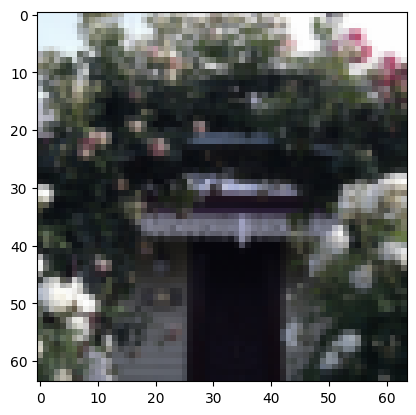

In [90]:
show_image_prediction(*valid_data[9])

In [94]:
torch.save(model.state_dict(),'flowers-resnet9.pth')